 ---

# Word2vec 
---

**Word2vec** is a technique for natural language processing published in 2013.

The **Word2vec** algorithm uses a neural network model to learn word associations from a large corpus of text.

Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. 

As the name implies, **Word2vec** represents each distinct word with a particular list of numbers called a vector.

The vectors are chosen carefully such that a simple mathematical function (the cosine similarity between the vectors) indicates the level of semantic similarity between the words represented by those vectors.

**Word2vec** really refers to two models for learning word vectors:
* continuous bag-of-words (CBOW)
* skip-gram model.

The key insight behind **Word2vec** is that ‘a word is known by the company it keeps’. Concretely,
consider a ‘center’ word c surrounded before and after by a context of a certain length. We term words in
this contextual window ‘outside words’ (O). For example, in the following figure, the context window length is 2, the
center word c is ‘banking’, and the outside words are ‘turning’, ‘into’, ‘crises’, and ‘as’:
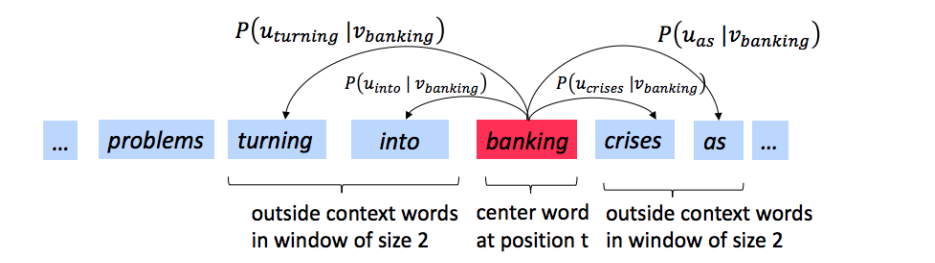


Skip-gram word2vec aims to learn the probability distribution $P(O|C)$. 
Specifically, given a specific word $ o $ and a specific word $c$, we want to predict $P(O=o|C=c)$: the probability that word $o$ is an `outside' word for $c$ (i.e., that it falls within the contextual window of $c$).
We model this probability by taking the softmax function over a series of vector dot-products: 


<center> $  P(O=o \mid C=c) = \frac{\exp(\ u_{o}^\top  v_c)}{\sum_{w \in \text{Vocab}} \exp( u_{w}^\top v_c)} $ </center>


For each word, we learn vectors $u$ and $v$, where $ u_o$ is the 'outside' vector representing outside word $o$ , and $ v_c$ is the 'center' vector representing center word $c$. 
We store these parameters in two matrices, $ U$ and $ V$.
The columns of $ U$ are all the 'outside' vectors $\ u_{w}$;
the columns of $ V$ are all of the 'center' vectors $ v_{w}$. 
Both $ U$ and $ V$ contain a vector for every $w \in \text{Vocabulary}$.



In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

from utils.sgd import *

from utils.utils import normalizeRows, softmax, sigmoid
from utils.treebank import StanfordSentiment


for a single pair of words $c$ and $o$, the loss is given by:

\begin{equation} 
 J_{\text{naive-softmax}}( v_c, o,  U) = -\log P(O=o| C=c).
\label{naive-softmax}
\end{equation}

The partial derivative of $J_{\text{naive-softmax}}( v_c, o, U)$ with respect to $ v_c$.


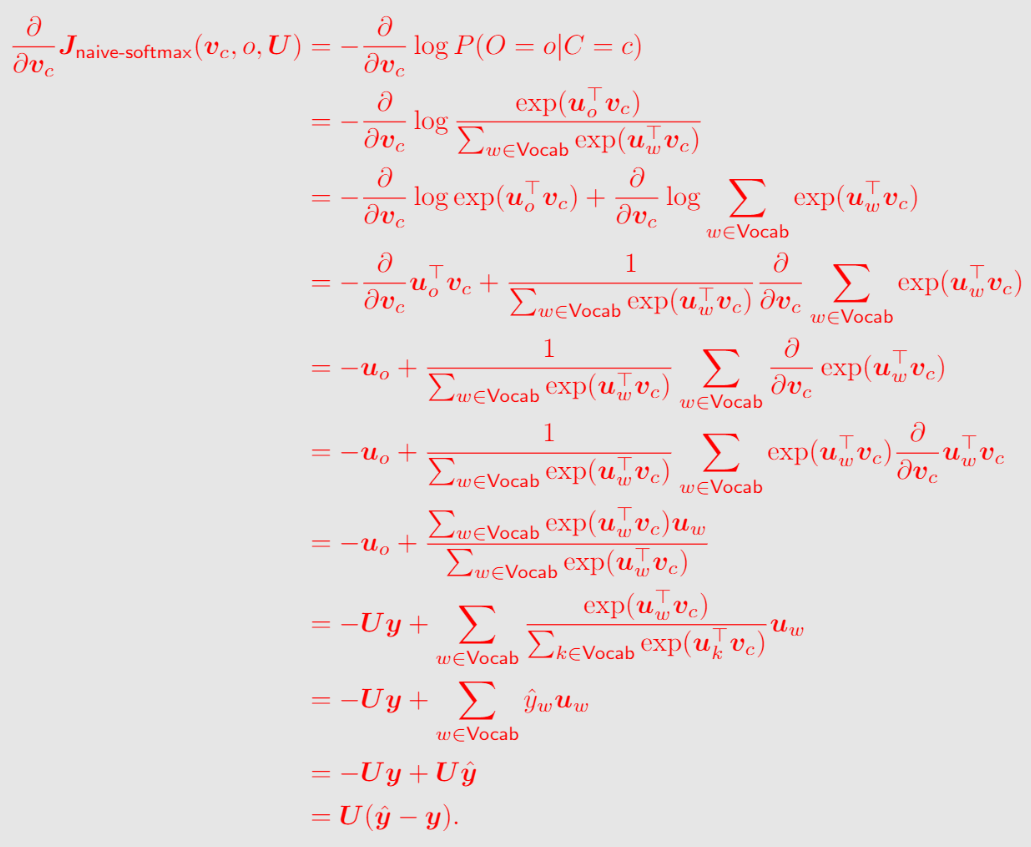


The partial derivatives of $ J_{\text{naive-softmax}}( v_c, o, U)$ with respect to each of the 'outside' word vectors, $ u_w$

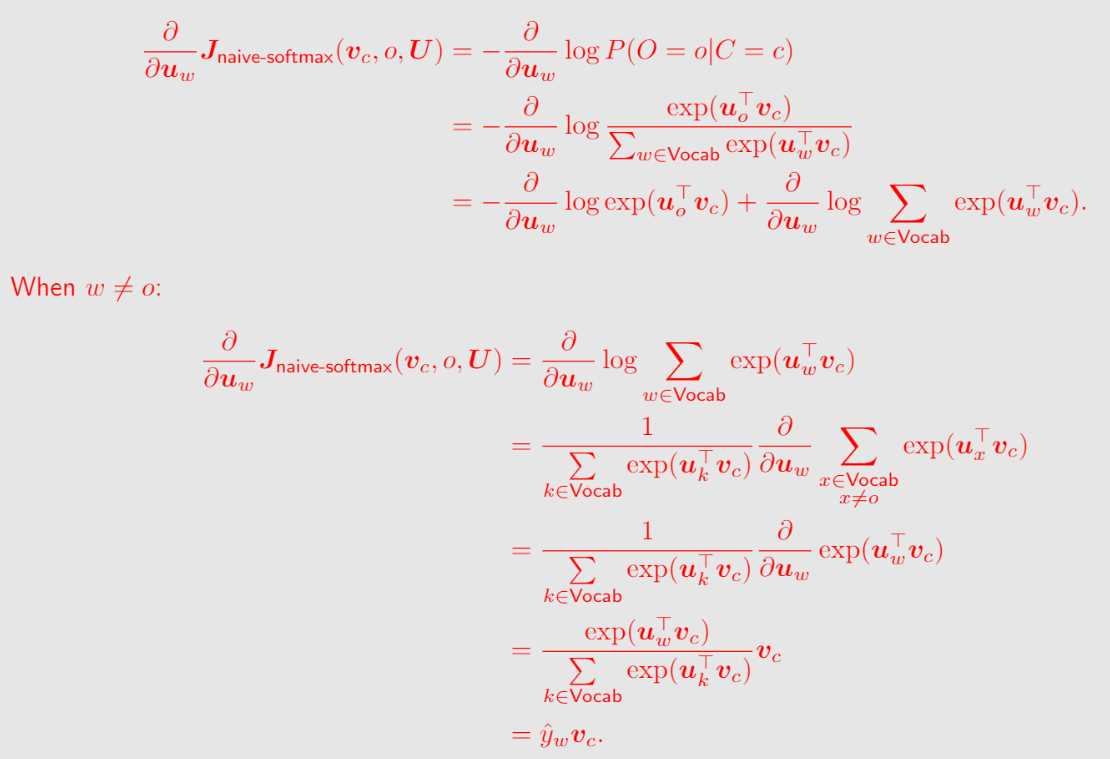


In [ ]:
def naiveSoftmaxLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset
):
    """ Naive Softmax loss & gradient function for word2vec models

    Implementation of  the naive softmax loss and gradients between a center word's 
    embedding and an outside word's embedding. This will be the building block
    for our word2vec models. 

    Arguments:
    centerWordVec -- numpy ndarray, center word's embedding
                    in shape (word vector length, )
                    (v_c in the formula above)
    outsideWordIdx -- integer, the index of the outside word
                    (o of u_o in the formula above)
    outsideVectors -- outside vectors is
                    in shape (num words in vocab, word vector length) 
                    for all words in vocab (tranpose of U in the formula above)
    dataset -- needed for negative sampling, unused here.

    Return:
    loss -- naive softmax loss
    gradCenterVec -- the gradient with respect to the center word vector
                     in shape (word vector length, )
                     (dJ / dv_c in the formula above)
    gradOutsideVecs -- the gradient with respect to all the outside word vectors
                    in shape (num words in vocab, word vector length) 
                    (dJ / dU)
    """

    softmax_vect = softmax(outsideVectors @ centerWordVec)
    loss = -np.log(softmax_vect[outsideWordIdx])

    gradCenterVec = - outsideVectors[outsideWordIdx] + outsideVectors.T @ softmax_vect

    gradOutsideVecs = softmax_vect.reshape(-1, 1) @ centerWordVec.reshape(1, -1)
    gradOutsideVecs[outsideWordIdx] = (softmax_vect[outsideWordIdx] - 1) * centerWordVec # w != o
    
    return loss, gradCenterVec, gradOutsideVecs

A problem comes up when we want to calculate the denominator of,

<center> $  P(O=o \mid C=c) = \frac{\exp(\ u_{o}^\top  v_c)}{\sum_{w \in \text{Vocab}} \exp( u_{w}^\top v_c)} $ </center>

which is a normalizing factor that has to be computed over the entire vocabulary. Considering the fact the size of the vocabulary can reach hundreds of thousands or even several million words, the computation becomes intractable. This is where negative sampling comes into play and makes this computation feasible

In a nutshell, by defining a new objective function, negative sampling aims at maximizing the similarity of the words in the same context and minimizing it when they occur in different contexts. However, instead of doing the minimization for all the words in the dictionary except for the context words, it randomly selects a handful of words $(2 \le k \le 20)$

Assume that $K$ negative samples (words) are drawn from the vocabulary. For simplicity of notation we shall refer to them as $w_1, w_2, \dots, w_K$, and their outside vectors as $ u_{w_1}, u_{w_2}, \dots, u_{w_K}$. 

Note that $o\notin\{w_1, \dots, w_K\}$. 
For a center word $c$ and an outside word $o$, the negative sampling loss function is given by:

\begin{equation}
 J_{\text{neg-sample}}( v_c, o,  U) = -\log(\sigma( u_o^\top  v_c)) - \sum_{s=1}^K \log(\sigma(- u_{w_s}^\top  v_c))
\end{equation}

The partial derivative of $J_{\text{neg-sample}}( v_c, o, U)$ with respect to $ v_c$

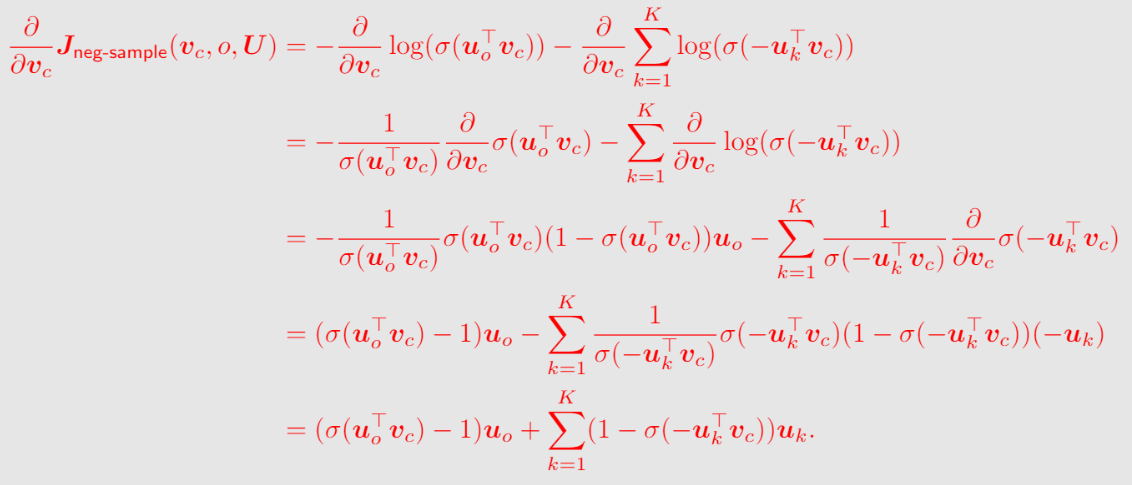


The partial derivative of $J_{\text{neg-sample}}( v_c, o, U)$ with respect to $\ u_o$,

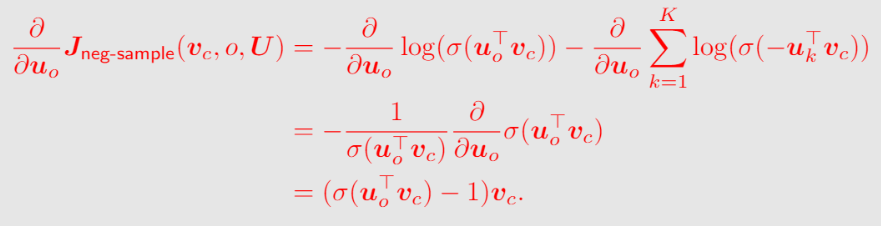

The partial derivative of $J_{\text{neg-sample}}( v_c, o, U)$ with respect to  $s^{th}$ negative sample $ u_{w_s}$. 

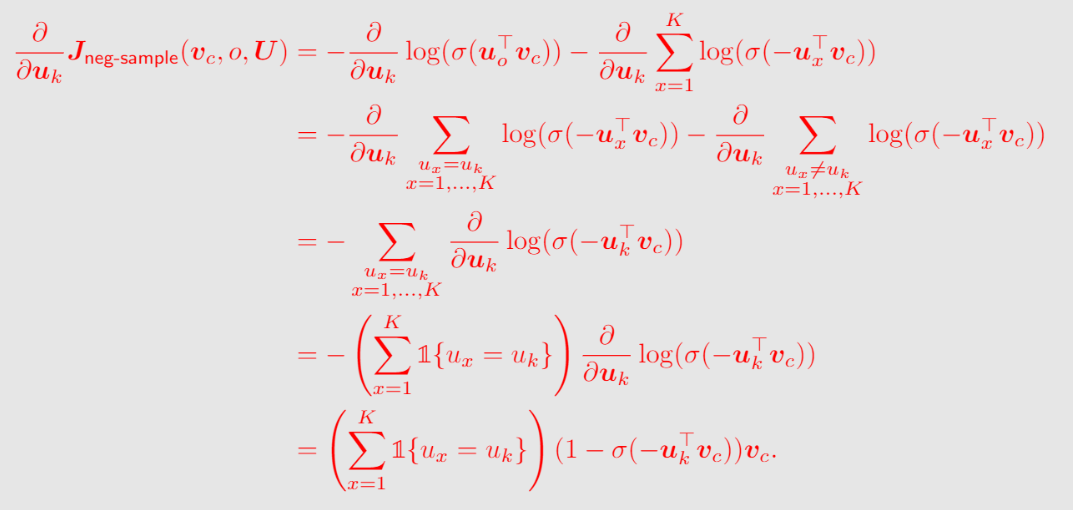

In [ ]:
def getNegativeSamples(outsideWordIdx, dataset, K):
    """ Samples K indexes which are not the outsideWordIdx """

    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return negSampleWordIndices

In [ ]:
def negSamplingLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset,
    K=10
):
    """ Negative sampling loss function for word2vec models

    Implementation of  the negative sampling loss and gradients for 
    a centerWordVec and a outsideWordIdx word vector as a building block
    for word2vec models. K is the number of negative samples to take.

    Note: The same word may be negatively sampled multiple times. 

    Arguments/Return Specifications: same as naiveSoftmaxLossAndGradient
    """

    negSampleWordIndices = getNegativeSamples(outsideWordIdx, dataset, K)
    indices = [outsideWordIdx] + negSampleWordIndices

    scores = outsideVectors[indices] @ centerWordVec # (K+1,)
    sigmoid_neg_score_ks = sigmoid(-scores[1:]).reshape(-1, 1) # (K, 1)

    loss = -np.log(sigmoid(scores[0])) - np.sum(np.log(sigmoid_neg_score_ks))

    tmp_k = (1 - sigmoid_neg_score_ks) * outsideVectors[negSampleWordIndices] # (K, d)
    gradCenterVec = (sigmoid(scores[0]) - 1) * outsideVectors[outsideWordIdx] \
        + np.sum(tmp_k, axis=0) # (d,)

    gradOutsideVecs = np.zeros_like(outsideVectors) # (V, d)
    gradOutsideVecs[outsideWordIdx] = (sigmoid(scores[0]) - 1) * centerWordVec # (d,)
    # Count for duplications:
    for i, k in enumerate(negSampleWordIndices):
        gradOutsideVecs[k] += (1 - sigmoid_neg_score_ks[i]) * centerWordVec # (d, )

    return loss, gradCenterVec, gradOutsideVecs

Suppose the center word is $c = w_t$ and the context window is $[w_{t-m}$, $\ldots$, $w_{t-1}$, $w_{t}$, $w_{t+1}$, $\ldots$, $w_{t+m}]$, where $m$ is the context window size. Recall that for the  skip-gram version of {\tt word2vec}, the total loss for the context window is:

\begin{equation}
\label{skip-gram}
 J_{\textrm{skip-gram}}( v_c, w_{t-m},\ldots w_{t+m}, U) = \sum_{\substack{-m\le j \le m \\ j\ne 0}}  J( v_c, w_{t+j}, U)
\end{equation}


Here, $ J( v_c, w_{t+j},  U)$ represents an arbitrary loss term for the center word $c=w_t$ and outside word $w_{t+j}$. $ J( v_c, w_{t+j}, U)$ could be $ J_{\text{naive-softmax}}( v_c, w_{t+j},  U)$ or $ J_{\text{neg-sample}}( v_c, w_{t+j},  U)$, depending on your implementation.


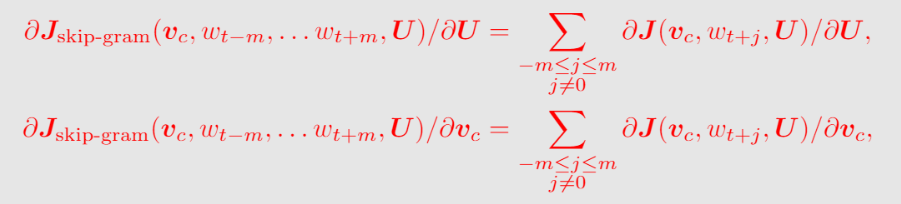

In [ ]:
def skipgram(currentCenterWord, windowSize, outsideWords, word2Ind,
             centerWordVectors, outsideVectors, dataset,
             word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    """ Skip-gram model in word2vec

    Implementation of the skip-gram model in this function.

    Arguments:
    currentCenterWord -- a string of the current center word
    windowSize -- integer, context window size
    outsideWords -- list of no more than 2*windowSize strings, the outside words
    word2Ind -- a dictionary that maps words to their indices in
              the word vector list
    centerWordVectors -- center word vectors (as rows) is in shape 
                        (num words in vocab, word vector length) 
                        for all words in vocab (V in pdf handout)
    outsideVectors -- outside vectors is in shape 
                        (num words in vocab, word vector length) 
                        for all words in vocab (transpose of U in the pdf handout)
    word2vecLossAndGradient -- the loss and gradient function for
                               a prediction vector given the outsideWordIdx
                               word vectors, could be one of the two
                               loss functions you implemented above.

    Return:
    loss -- the loss function value for the skip-gram model
            (J in the pdf handout)
    gradCenterVec -- the gradient with respect to the center word vector
                     in shape (num words in vocab, word vector length)
                     (dJ / dv_c in the pdf handout)
    gradOutsideVecs -- the gradient with respect to all the outside word vectors
                    in shape (num words in vocab, word vector length) 
                    (dJ / dU)
    """

    loss = 0.0
    gradCenterVecs = np.zeros(centerWordVectors.shape)
    gradOutsideVectors = np.zeros(outsideVectors.shape)

    centerWordVec = centerWordVectors[word2Ind[currentCenterWord]]
        
    for outsideWord in outsideWords:
        loss_j, gradCenterVecs_j, gradOutsideVectors_j = word2vecLossAndGradient(
            centerWordVec, word2Ind[outsideWord], outsideVectors, dataset)
        
        loss += loss_j
        gradCenterVecs[word2Ind[currentCenterWord]] += gradCenterVecs_j
        gradOutsideVectors += gradOutsideVectors_j
    
    return loss, gradCenterVecs, gradOutsideVectors

In [ ]:
def word2vec_sgd_wrapper(word2vecModel, word2Ind, wordVectors, dataset,
                         windowSize,
                         word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    batchsize = 50
    loss = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    centerWordVectors = wordVectors[:int(N/2),:]
    outsideVectors = wordVectors[int(N/2):,:]
    for i in range(batchsize):
        windowSize1 = random.randint(1, windowSize)
        centerWord, context = dataset.getRandomContext(windowSize1)

        c, gin, gout = word2vecModel(
            centerWord, windowSize1, context, word2Ind, centerWordVectors,
            outsideVectors, dataset, word2vecLossAndGradient
        )
        loss += c / batchsize
        grad[:int(N/2), :] += gin / batchsize
        grad[int(N/2):, :] += gout / batchsize

    return loss, grad

In [ ]:
random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# We are going to train 10-dimensional vectors for this assignment
dimVectors = 10

# Context size
C = 5

In [ ]:
startTime=time.time()
wordVectors = np.concatenate(
    ((np.random.rand(nWords, dimVectors) - 0.5) /
       dimVectors, np.zeros((nWords, dimVectors))),
    axis=0)
wordVectors = sgd(
    lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C,
        negSamplingLossAndGradient),
    wordVectors, 0.3, 40000, None, True, PRINT_EVERY=10)
# Note that normalization is not called here. This is not a bug,
# normalizing during training loses the notion of length.

print("sanity check: cost at convergence should be around or below 10")
print("training took %d seconds" % (time.time() - startTime))

In [ ]:
wordVectors = np.concatenate(
    (wordVectors[:nWords,:], wordVectors[nWords:,:]),
    axis=0)

visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet", "enjoyable", "boring", "bad", "dumb",
    "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]

visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2])

for i in range(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i],
        bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

plt.savefig('word_vectors.png')

## <font color="blue"> Reference </font>

1. [Stanford CS224n lecture note](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf)
2. [NLP’s word2vec: Negative Sampling Explained](https://www.baeldung.com/cs/nlps-word2vec-negative-sampling#:~:text=In%20a%20nutshell%2C%20by%20defining,they%20occur%20in%20different%20contexts.)
3. [Word2vec Wikioedia](https://en.wikipedia.org/wiki/Word2vec)